### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Matplotlib is building the font cache; this may take a moment.


### Loading dataset

In [2]:
calories = pd.read_csv("calories.csv")
exercise_data = pd.read_csv("exercise.csv")

In [3]:
calories.head(10)

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0
5,15130815,123.0
6,19602372,112.0
7,11117088,143.0
8,12132339,134.0
9,17964668,72.0


In [4]:
exercise_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


We have to combine the two dataframes in order to train the model and do some analysis. We need the entire "exercise_data" dataset and only the "Calories" column from "calories dataset" 

In [5]:
calories_data = pd.concat([exercise_data, calories['Calories']], axis=1)

In [6]:
calories_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


### EDA

##### Non-graphical analysis

In [8]:
# Checking dimensions
calories_data.shape

(15000, 9)

We have 15000 rows and 9 columns of data

In [9]:
# Checking column datatypes and nulls
calories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


We have no missing values in all columns, 1 categorical (nominal) variable and 8 numerical variables.

In [14]:
# Lets get descriptive stats about the dataset
calories_data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [15]:
# Checking if we have outliers
calories_data.kurtosis()

C:\Users\201649578\AppData\Local\Temp\ipykernel_6716\205508607.py:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  calories_data.kurtosis()


User_ID      -1.194119
Age          -0.949130
Height       -0.513210
Weight       -0.682057
Duration     -1.184751
Heart_Rate   -0.644220
Body_Temp     0.517306
Calories     -0.717763
dtype: float64

Non of the attributes are > 3 so we don't have outliers

In [16]:
calories_data.skew()

C:\Users\201649578\AppData\Local\Temp\ipykernel_6716\3691617327.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  calories_data.skew()


User_ID       0.004788
Age           0.473383
Height       -0.006190
Weight        0.226725
Duration      0.004751
Heart_Rate   -0.010704
Body_Temp    -0.994382
Calories      0.505371
dtype: float64

* Age, Height, Weight, Duration, Heart_Rate are fairly symmetrical
* Body_Temp is moderately negatively skewed and Calories is moderately positively skewed

In [17]:
calories_data.corr()

C:\Users\201649578\AppData\Local\Temp\ipykernel_6716\683745613.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  calories_data.corr()


,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,1.000000,-0.001827,-0.013520,-0.011603,-0.002751,-0.000457,0.000923,-0.001661
Age,-0.001827,1.000000,0.009554,0.090094,0.013247,0.010482,0.013175,0.154395
Height,-0.013520,0.009554,1.000000,0.958451,-0.004625,0.000528,0.001200,0.017537
Weight,-0.011603,0.090094,0.958451,1.000000,-0.001884,0.004311,0.004095,0.035481
Duration,-0.002751,0.013247,-0.004625,-0.001884,1.000000,0.852869,0.903167,0.955421
Heart_Rate,-0.000457,0.010482,0.000528,0.004311,0.852869,1.000000,0.771529,0.897882
Body_Temp,0.000923,0.013175,0.001200,0.004095,0.903167,0.771529,1.000000,0.824558
Calories,-0.001661,0.154395,0.017537,0.035481,0.955421,0.897882,0.824558,1.000000


* Age, Height and Weight are all **weakly positively correlated** to Calories burnt
* Duration, Heart_Rate and Body_Temp are all **strongly correlated** to Calories burnt
* <code style="background:red;color:black">Strong multicollinearity between Duration, Heart_Rate and Body_Temp.</code>

In [21]:
# Counting the genders
calories_data["Gender"].value_counts()

female    7553
male      7447
Name: Gender, dtype: int64

##### Graphical analysis

Checking for Linearity

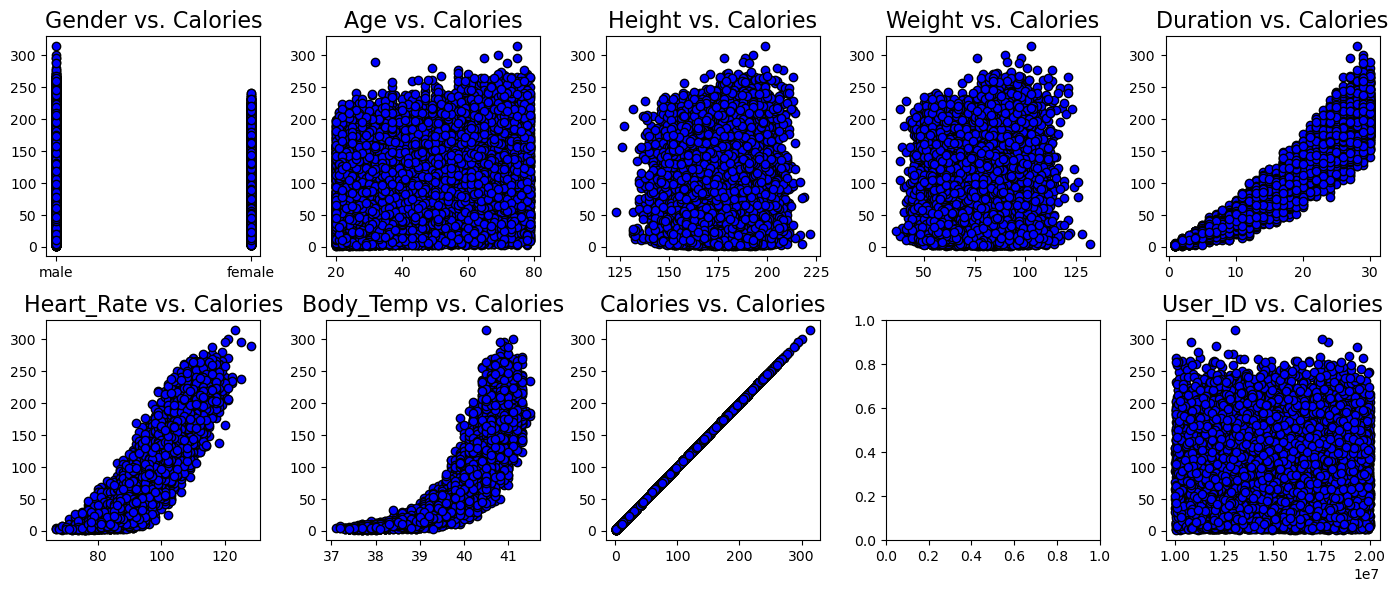

In [24]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(calories_data.columns):
    axs[index-1].set_title("{} vs. Calories".format(column),fontsize=16)
    axs[index-1].scatter(x=calories_data[column],y=calories_data['Calories'],color='blue',edgecolor='k')
    
fig.tight_layout(pad=1)

* There's vey **litle to no relationship** between Calories and Age, Height and Weight
* There's a **strong linear relatioship** between Calories and Duration as we as Heart_Rate
* Calories and Body_Temp have a strong relationship but it's exponential

There seems to be little linearity present, so a Linear regression model would perform poor

Checking for multicollinearity

In [25]:
calories_data1 = calories_data.copy()

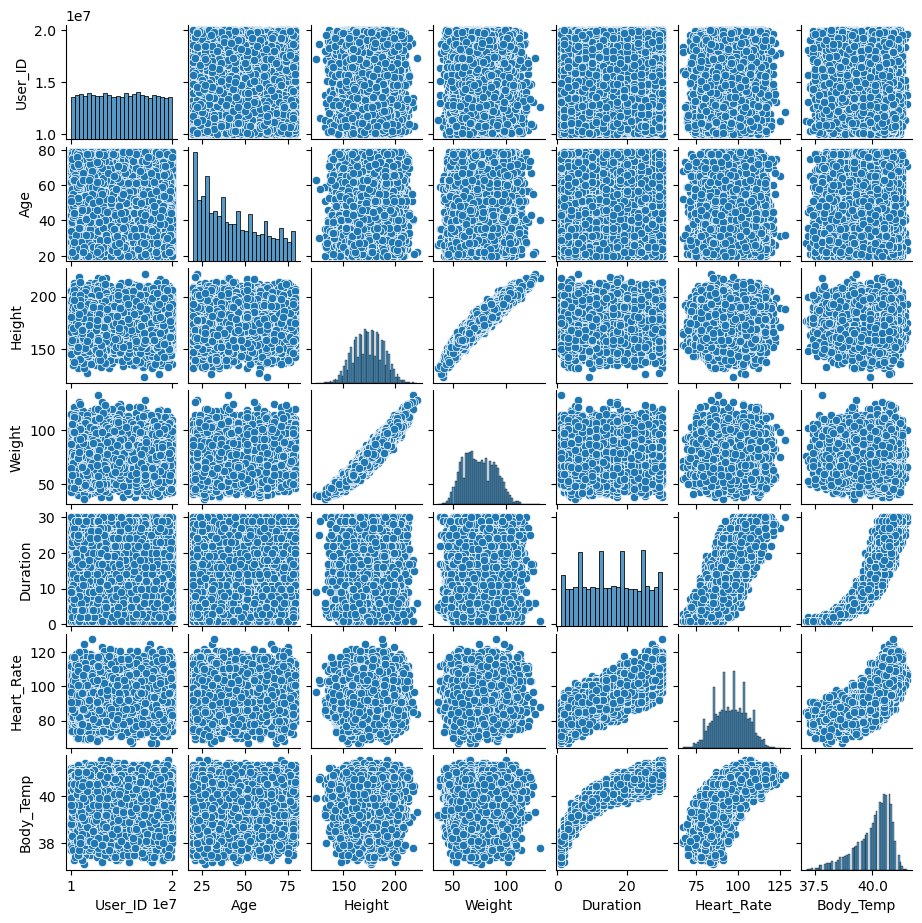

In [26]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(calories_data1.drop('Calories', axis='columns'))
g.fig.set_size_inches(9,9)

* <code style="background:red;color:black">Strong multicollinearity between Duration, Heart_Rate and Body_Temp.</code>

We'll see how to deal with this

C:\Users\201649578\AppData\Local\Temp\ipykernel_6716\2258737221.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(calories_data.corr(), dtype=bool))
C:\Users\201649578\AppData\Local\Temp\ipykernel_6716\2258737221.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(calories_data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)


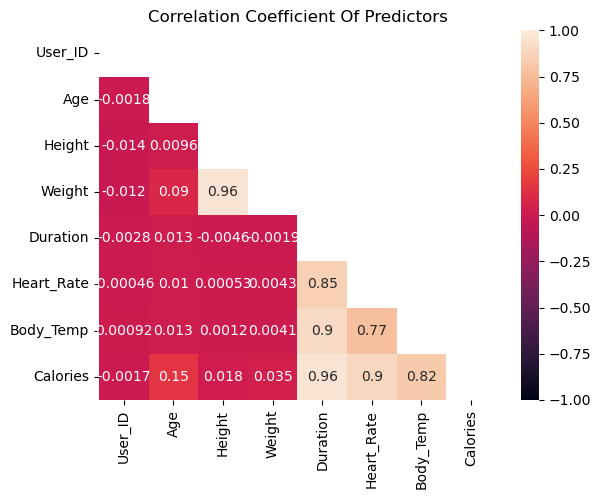

In [28]:
mask = np.triu(np.ones_like(calories_data.corr(), dtype=bool))

sns.heatmap(calories_data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [29]:
calories_data.replace({"Gender":{'male':0,'female':1}}, inplace=True)

In [30]:
calories_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


In [31]:
X = calories_data.drop(columns=['User_ID','Calories'], axis=1)
Y = calories_data['Calories']

In [33]:
X

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,0,68,190.0,94.0,29.0,105.0,40.8
1,1,20,166.0,60.0,14.0,94.0,40.3
2,0,69,179.0,79.0,5.0,88.0,38.7
3,1,34,179.0,71.0,13.0,100.0,40.5
4,1,27,154.0,58.0,10.0,81.0,39.8
...,...,...,...,...,...,...,...
14995,1,20,193.0,86.0,11.0,92.0,40.4
14996,1,27,165.0,65.0,6.0,85.0,39.2
14997,1,43,159.0,58.0,16.0,90.0,40.1
14998,0,78,193.0,97.0,2.0,84.0,38.3


In [34]:
Y

0        231.0
1         66.0
2         26.0
3         71.0
4         35.0
         ...  
14995     45.0
14996     23.0
14997     75.0
14998     11.0
14999     98.0
Name: Calories, Length: 15000, dtype: float64

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [36]:
print(X.shape, X_train.shape, X_test.shape)

(15000, 7) (12000, 7) (3000, 7)


In [37]:
# loading the model
model = XGBRegressor()

In [38]:
# training the model with X_train
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
test_data_prediction = model.predict(X_test)

In [40]:
test_data_prediction

array([127.823784, 226.00154 ,  38.66253 , ..., 144.3636  ,  22.767195,
        89.87375 ], dtype=float32)

In [41]:
mae = metrics.mean_absolute_error(Y_test, test_data_prediction)

In [42]:
print("Mean Absolute Error = ", mae)

Mean Absolute Error =  1.4807048829992613
